In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sympy import symbols, diff
warnings.filterwarnings('ignore', 'overflow encountered in exp')

np.random.seed(13)

In [2]:
df = pd.DataFrame(pd.read_csv('data/digit recognizer/train.csv'))
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We will use binary classification. This means we will only use numbers one and zero first, before doing a more complex classification problem with multiple numbers.

In [3]:
df_binary = df.loc[df['label'].isin([0, 1])]
x_train = df_binary.drop("label", axis=1)
y_train = df_binary["label"]

m, n = x_train.shape

Plot data

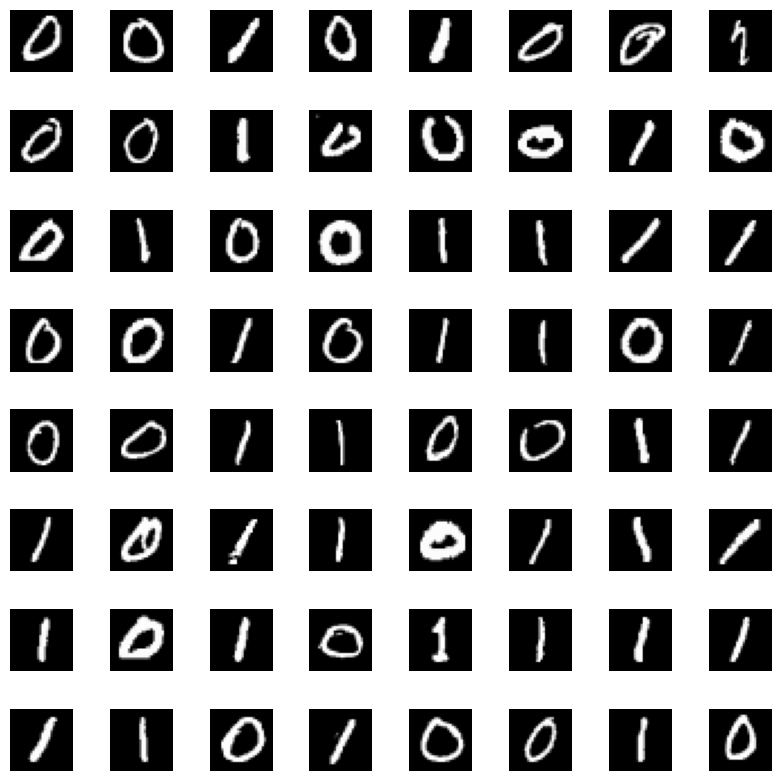

In [4]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1)

for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = x_train.iloc[random_index].values.reshape((28, 28))
    
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    #ax.set_title(y_train[random_index])
    ax.set_axis_off()


# Neural Network

## Model

### Tensorflow Implementation

The neural network will be implemented first with tensorflow and then using our on math implementation with numpy.The NN will have this caracteristics:

- Three dense layers with sigmoid activations functions.
    - Inputs are pixel values of digit images.
    - Since the images are of size $28\times28$, this gives us $784$ inputs 

- The parameters have dimensions that are sized for a neural network with $25$ units in layer 1, $15$ units in layer 2 and $1$ output unit in layer 3. 

    - Recall that the dimensions of these parameters are determined as follows:
        - If network has $s_{in}$ units in a layer and $s_{out}$ units in the next layer, then 
            - $W$ will be of dimension $s_{in} \times s_{out}$.
            - $b$ will a vector with $s_{out}$ elements
  
    - Therefore, the shapes of `W`, and `b`,  are 
        - layer1: The shape of `W1` is (400, 25) and the shape of `b1` is (25,)
        - layer2: The shape of `W2` is (25, 15) and the shape of `b2` is: (15,)
        - layer3: The shape of `W3` is (15, 1) and the shape of `b3` is: (1,)
>**Note:** The bias vector `b` could be represented as a 1-D (n,) or 2-D (1,n) array. Tensorflow utilizes a 1-D representation and this lab will maintain that convention. 

First let's implement with tensorflow.

Tensorflow models are built layer by layer. A layer's input dimensions ($s_{in}$ above) are calculated automatically. The layer's *output dimensions* are specified and it determines the next layer's input dimension. The input dimension of the first layer is derived from the size of the input data specified in the `model.fit` statement below. 
>**Note:** It is also possible to add an input layer that specifies the input dimension of the first layer. For example:  
`tf.keras.Input(shape=(400,)),    #specify input shape`  
We will include that here to illuminate some model sizing.

In [5]:
model = Sequential(
    [               
        tf.keras.Input(shape=(784,)),    # the images are 28 x 28 = 784
        Dense(units=25, activation='sigmoid'),
        Dense(units=15, activation='sigmoid'),
        Dense(units=1, activation='sigmoid')
        
    ], name = "my_model" 
)  

In [6]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 25)             │        19,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,031 (78.25 KB)

 Trainable params: 20,031 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

Layer n num params = W[n] + b[n]
$$

L_1 = 769 * 25 + 25 = 19.625 \\
L2 = 25 * 15 + 15 = 390 \\
L3 = 15 * 1 + 1 = 16
$$

We can examine details of the model by first extracting the layers with `model.layers` and then extracting the weights with `layerx.get_weights()` as shown below.

In [7]:
[layer1, layer2, layer3] = model.layers

# Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (784, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 1), b3 shape = (1,)


`xx.get_weights` returns a NumPy array. One can also access the weights directly in their tensor form. Note the shape of the tensors in the final layer.

In [8]:
print(model.layers[2].weights)

[<KerasVariable shape=(15, 1), dtype=float32, path=my_model/dense_2/kernel>, <KerasVariable shape=(1,), dtype=float32, path=my_model/dense_2/bias>]


We will define a loss function and run gradient descent to fit the weights of the model to the training data.

In [9]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    x_train, y_train,
    epochs=20
)

Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - loss: 0.3474
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 0.0453
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0199
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 0.0141
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 0.0099
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 0.0081
Epoch 7/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 0.0053
Epoch 8/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 0.0040
Epoch 9/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.0031
Epoch 10/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 0.0042
Epoch 11/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 0.0035
Epoch 12/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 0.0022
Epoch 13/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 0.0022
Epoch 14/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 0.0019 
Epoch 15/20
276/276 ━━━━━━━━━━

The model predicts the probability that the input is a one is nearly one and the probability of a zero input to be one is nearly a zero. As in the case of logistic regression, the probability is compared to a threshold to make a final prediction.

In [10]:
def prediction_thold(prediction):
    if prediction >= 0.5:
        yhat = 1
    else:
        yhat = 0
    
    return yhat

Now we will make predictions.

In [11]:
prediction = model.predict(x_train.iloc[[1]])  # a one
print(f" predicting a zero: {prediction}")
print(f"prediction after threshold: {prediction_thold(prediction)}")
prediction = model.predict(x_train.iloc[[0]])  # a zero
print(f" predicting a one:  {prediction}")
print(f"prediction after threshold: {prediction_thold(prediction)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
 predicting a zero: [[0.00045134]]
prediction after threshold: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
 predicting a one:  [[0.9997749]]
prediction after threshold: 1


### Numpy Implementation (Forward Prop)

In [12]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
    """
    
    return 1/(1 + np.exp(-z))

def dense_layer(a_in, w, b, g):
    
    # Alternative using dot product:
    '''
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):
        a_out[j] = np.dot(W[:, j], a_in) + b[j]
    a_out = g(a_out)
    '''
    
    # Using matrix multiplication
    a_out = g(np.matmul(a_in, w) + b)
    
    return a_out

def sequential(a_in, w, b):
    
    for i in range(len(w)):
        a_out = dense_layer(a_in, w[i], b[i], sigmoid)
        a_in = a_out
    
    return(a_out)

By coping tensorflow weights we can test our numpy model

In [13]:
W_tmp=[]
b_tmp=[]
W1_tmp,b1_tmp = layer1.get_weights()
W2_tmp,b2_tmp = layer2.get_weights()
W3_tmp,b3_tmp = layer3.get_weights()

W_tmp = [W1_tmp, W2_tmp, W3_tmp]
b_tmp = [b1_tmp, b2_tmp, b3_tmp]

In [14]:
prediction = sequential(x_train.iloc[0], W_tmp, b_tmp)
print(f"prediction: {prediction_thold(prediction)}, label= {y_train.iloc[0]}")

prediction = sequential(x_train.iloc[1], W_tmp, b_tmp)
print(f"prediction: {prediction_thold(prediction)}, label= {y_train.iloc[1]}")


prediction: 1, label= 1
prediction: 0, label= 0


Plot predictions with both models

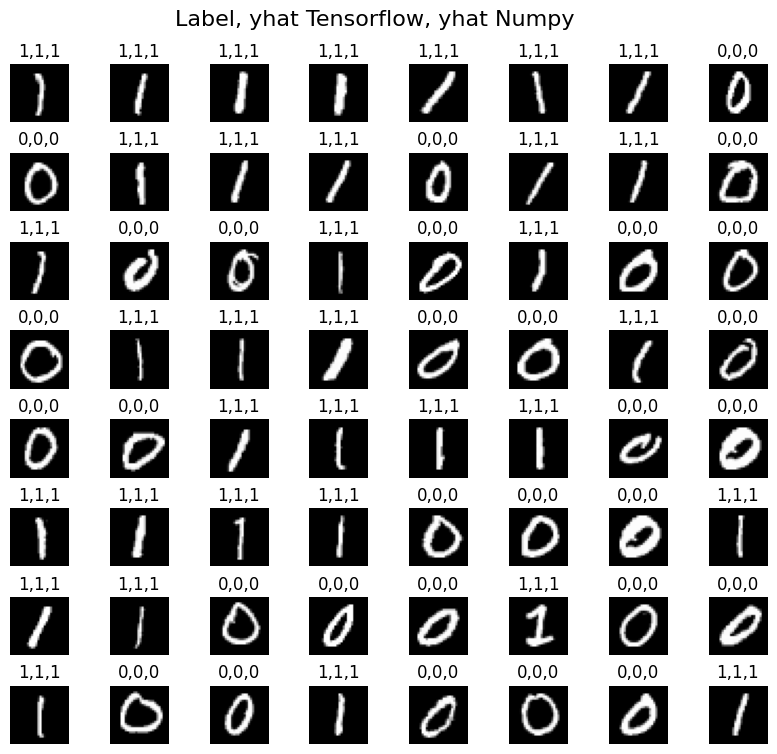

In [15]:
n = x_train.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = x_train.iloc[random_index].values.reshape((28, 28))
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Predict using the Neural Network implemented in Numpy
    my_prediction = prediction_thold(sequential(x_train.iloc[random_index], W_tmp, b_tmp))

    # Predict using the Neural Network implemented in Tensorflow
    tf_prediction = prediction_thold(model.predict(x_train.iloc[[random_index]], verbose = 0))
    
    # Display the label above the image
    ax.set_title(f"{y_train.iloc[random_index]},{tf_prediction},{my_prediction}")
    ax.set_axis_off() 
fig.suptitle("Label, yhat Tensorflow, yhat Numpy", fontsize=16)
plt.show()

## Multi-Class Classification

A network of this type will have multiple units in its final layer. Each output is associated with a category. When an input example is applied to the network, the output with the highest value is the category predicted. If the output is applied to a softmax function, the output of the softmax will provide probabilities of the input being in each category. 

### Softmax Function

The softmax function takes a vector of arbitrary real-valued scores (often called logits) as input and normalizes them into a probability distribution consisting of values between 0 and 1 that sum up to 1. This normalization makes it suitable for multiclass classification as it allows the network to output probabilities for each class.

$$
softmax(z)_i = \frac{e^{z_i}}{\sum\limits_{j=1}^{N} e^{z_j}} \tag{1}
$$


Where:

* $e$ denotes the base of the natural logarithm (Euler's number)
* $N$ represents the number of classes. 

The exponential function in the numerator ensures that the output values are positive, and the denominator sums up all these exponentiated values across all classes, providing normalization.

The output $\mathbf{z}$ is a vector of length N, so for softmax regression, you could also write:

$$
\begin{align}
\mathbf{z}(x) =
\begin{bmatrix}
P(y = 1 | \mathbf{x}; \mathbf{w},b) \\
\vdots \\
P(y = N | \mathbf{x}; \mathbf{w},b)
\end{bmatrix}
=
\frac{1}{ \sum_{k=1}^{N}{e^{z_k} }}
\begin{bmatrix}
e^{z_1} \\
\vdots \\
e^{z_{N}} \\
\end{bmatrix} \tag{2}
\end{align}
$$

Which shows the output is a vector of probabilities. The first entry is the probability the input is the first category given the input $\mathbf{x}$ and parameters $\mathbf{w}$ and $\mathbf{b}$.  
Let's create a NumPy implementation:

In [16]:
def softmax(z):
    ez = np.exp(z)
    a = ez/np.sum(ez)
    return a

In [17]:
softmax([4, 3, 2, 1])

array([0.64391426, 0.23688282, 0.08714432, 0.0320586 ])

Some key properties of the softmax function include:

<ol>
  <li> 
  Non-linearity: Like other activation functions, softmax introduces non-linearity into the neural network, allowing it to learn complex patterns in the data.
  </li>
  
  <li> 
  Normalization: Softmax ensures that the output values represent a valid probability distribution over the classes, which is crucial for classification tasks.
  </li>

  <li> 
  Sensitivity to Large Inputs: Softmax tends to amplify differences between scores. If one logit is significantly larger than the others, its corresponding output probability will be close to 1, while the probabilities of other classes will be close to 0. This sensitivity can sometimes lead to numerical stability issues, especially if there are large differences in the input logits.
  </li>

  <li> Differentiability: Softmax is differentiable, which allows for efficient training of neural networks using gradient-based optimization algorithms like stochastic gradient descent (SGD) or Adam.
  </li>
</ol>

In [18]:
x_train = df.drop("label", axis=1)
y_train = df["label"]

m, n = x_train.shape

In [19]:
model = Sequential(
    [ 
        Dense(25, activation = 'relu'),
        Dense(15, activation = 'relu'),
        Dense(10, activation = 'softmax')    # < softmax activation here
    ]
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    x_train, y_train,
    epochs=10
)
        

Epoch 1/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - loss: 4.7624
Epoch 2/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - loss: 0.8869
Epoch 3/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - loss: 0.6857
Epoch 4/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 486us/step - loss: 0.6002
Epoch 5/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step - loss: 0.5548
Epoch 6/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - loss: 0.5308
Epoch 7/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - loss: 0.4898
Epoch 8/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - loss: 0.4675
Epoch 9/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - loss: 0.4408
Epoch 10/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - loss: 0.4105


In [20]:
model.predict(x_train.iloc[[1]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


array([[9.9985468e-01, 9.5436306e-08, 2.0582404e-05, 1.7767107e-06,
        1.0574929e-06, 6.9950374e-07, 1.1683533e-04, 4.8669898e-07,
        5.7685526e-07, 3.1560551e-06]], dtype=float32)

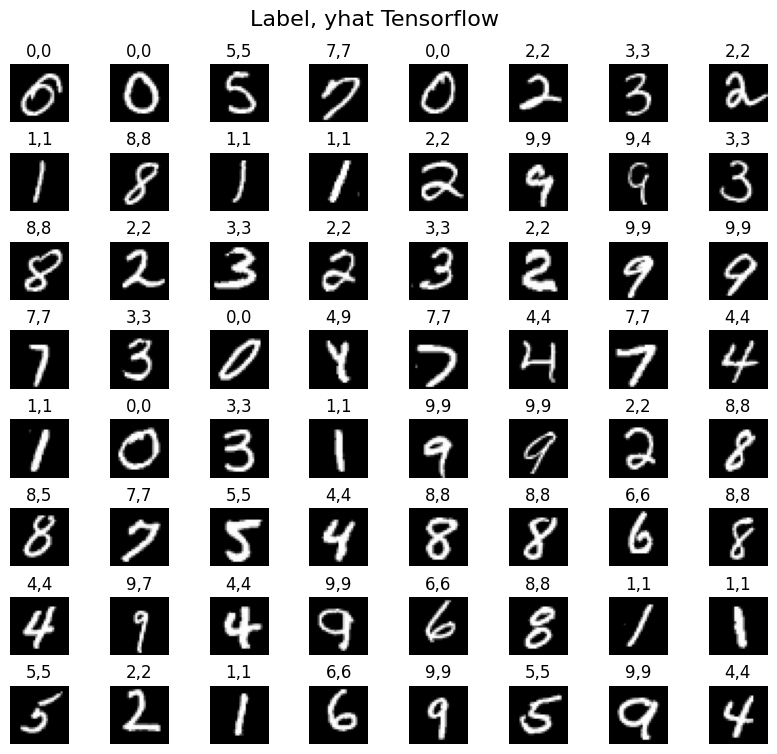

In [21]:
fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = x_train.iloc[random_index].values.reshape((28, 28))
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Predict using the Neural Network implemented in Tensorflow
    tf_prediction = model.predict(x_train.iloc[[random_index]], verbose = 0)
    tf_predicted_classes = np.argmax(tf_prediction)
    
    # Display the label above the image
    ax.set_title(f"{y_train.iloc[random_index]},{tf_predicted_classes}")
    ax.set_axis_off() 
fig.suptitle("Label, yhat Tensorflow", fontsize=16)
plt.show()

Andrew Ng explained that more stable and accurate results can be obtained if the softmax and loss are combined during training. This is enabled by the 'preferred' organization shown here.

In the preferred organization the final layer has a linear activation. For historical reasons, the outputs in this form are referred to as logits. The loss function has an additional argument: from_logits = True. This informs the loss function that the softmax operation should be included in the loss calculation. This allows for an optimized implementation.

In [22]:
preferred_model = Sequential(
    [ 
        Dense(25, activation = 'relu'),
        Dense(15, activation = 'relu'),
        Dense(10, activation = 'linear')   #<-- Note
    ]
)
preferred_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #<-- Note
    optimizer=tf.keras.optimizers.Adam(0.001),
)

preferred_model.fit(
    x_train, y_train,
    epochs=10
)
        

Epoch 1/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step - loss: 4.8022
Epoch 2/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step - loss: 1.1920
Epoch 3/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - loss: 0.8092
Epoch 4/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - loss: 0.6496
Epoch 5/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - loss: 0.5790
Epoch 6/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - loss: 0.5407
Epoch 7/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - loss: 0.5161
Epoch 8/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 474us/step - loss: 0.4577
Epoch 9/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 468us/step - loss: 0.4273
Epoch 10/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 468us/step - loss: 0.4187


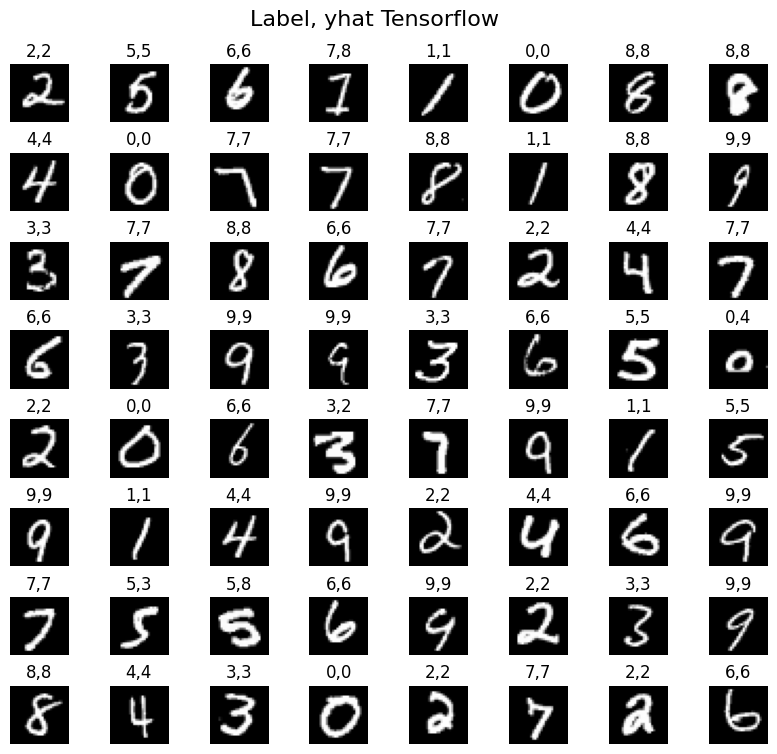

In [23]:
fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = x_train.iloc[random_index].values.reshape((28, 28))
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Predict using the Neural Network implemented in Tensorflow
    tf_prediction = preferred_model.predict(x_train.iloc[[random_index]], verbose = 0)
    tf_predicted_classes = np.argmax(tf_prediction)
    
    # Display the label above the image
    ax.set_title(f"{y_train.iloc[random_index]},{tf_predicted_classes}")
    ax.set_axis_off() 
fig.suptitle("Label, yhat Tensorflow", fontsize=16)
plt.show()

### SparseCategorialCrossentropy or CategoricalCrossEntropy
Tensorflow has two potential formats for target values and the selection of the loss defines which is expected.
- SparseCategorialCrossentropy: expects the target to be an integer corresponding to the index. For example, if there are 10 potential target values, y would be between 0 and 9. 
- CategoricalCrossEntropy: Expects the target value of an example to be one-hot encoded where the value at the target index is 1 while the other N-1 entries are zero. An example with 10 potential target values, where the target is 2 would be [0,0,1,0,0,0,0,0,0,0].


## Backpropagation

### Derivatives

The derivative of a function describes how the output of a function changes when there is a small change in an input variable.

If $w$ has a small change *epsilon* or $\epsilon$ (*delta* ($\Delta$)), the cost $J(w)$ changes by $k$ times that small change, then the derivative of $J(w)$ is equal to $k$.

$$
\begin{equation}
\text{if } w \uparrow \epsilon \text{ causes }J(w) \uparrow \text{by }k \times \epsilon \text{ then}  \\
\frac{\partial J(w)}{\partial w} = k \tag{1}
\end{equation}
$$

In backpropagation, it is useful to know the derivative of simple functions at any input value. To calculate a derivative, there are [differentiation rules](https://en.wikipedia.org/wiki/Differentiation_rules#Power_laws,_polynomials,_quotients,_and_reciprocals) that mathematicians have developed to solve for a derivative given an expression. This process can be automated with [SymPy](https://www.sympy.org/en/index.html).

In [24]:
J, w = symbols('J, w')

In [25]:
J=w**3
J

w**3

In [26]:
dJ_dw = diff(J,w)
dJ_dw

3*w**2

In [27]:
dJ_dw.subs([(w,2)])   # derivative at the point w=2

12

The *back propagation* algorithm is used to compute those derivatives. *Computation graphs* are used to simplify the operation.

In [28]:
class Layer:
    
    def __init__(self):
        self.a_in = None
        self.a_out = None
    
    def forward_prop(self, input):
        raise NotImplementedError
    
    def backward_prop(self, output_error, lr):
        raise NotImplementedError


In [29]:
class ConnectedLayer(Layer):
    '''
    input_size = number of input neurons
    output_size = number of output neurons
    w = weigths
    b = scalar
    '''
    
    def __init__(self, input_size, output_size):
        self.w  = np.random.rand(input_size, output_size)
        self.b  = np.random.rand(1, output_size)
    
    def get_weigths():
        return self.w
    
    def forward_prop(self, a_in):
        self.a_in = a_in
        self.a_out = np.matmul(a_in, self.w) + self.b
        
        return self.a_out
        
    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_prop(self, out_error, lr):
        dJ_dx = np.matmul(out_error, self.w.T)     # input error
        dJ_dw = np.matmul(self.a_in.T, out_error)  # weights error 
        dJ_db = out_error                       # output_error
        
        self.w -= lr * dJ_dw
        self.b -= lr * dJ_db
        
        return dJ_dx

In [30]:
class ActivationLayer(Layer):
    
    def __init__(self, activation, activation_dx):
        self.activation = activation
        self.activation_dx = activation_dx
    
    def forward_prop(self, a_in):
        self.a_in = a_in
        self.a_out = self.activation(a_in)
        
        return self.a_out

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_prop(self, output_error, learning_rate):
        return self.activation_dx(self.a_in) * output_error

Loss function (mean squared error) and its derivative

In [31]:
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1-np.tanh(x)**2

def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size

In [32]:
class Network:
    
    def __init__(self, loss=None, loss_dx=None):
        self.layers = []
        self.loss = loss
        self.loss_dx = loss_dx
    
    def add_layer(self, layer):
        self.layers.append(layer)
    
    def set_loss(self, loss, loss_dx):
        self.loss = loss
        self.loss_dx = loss_dx
    
    def predict(self, input_data):
        m = len(input_data)
        result = []
        
        for i in range(m):
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_prop(output)
            
            result.append(output)
        
        return result
    
    # train the network
    def fit(self, x_train, y_train, epochs, lr):
        m = len(x_train)
        losses = []
        
        for i in range(epochs):
            loss = 0
            
            for j in range(m):
                # forward propagation
                a_j = x_train[j]
                for layer in self.layers:
                    a_j = layer.forward_prop(a_j)

                # compute loss (for display purpose only)
                loss += self.loss(y_train[j], a_j)
                losses.append(loss)
                
                # backward propagation
                error = self.loss_dx(y_train[j], a_j)
                for layer in reversed(self.layers):
                    error = layer.backward_prop(error, lr)
            
            # calculate average error on all samples
            loss /= m
            print('epoch %d/%d   error=%f' % (i+1, epochs, loss))
        
        return losses

In [33]:
# # training data
# x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
# y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# # network
# net = Network()
# net.add_layer(ConnectedLayer(2, 3))
# net.add_layer(ActivationLayer(tanh, tanh_prime))
# net.add_layer(ConnectedLayer(3, 1))
# net.add_layer(ActivationLayer(tanh, tanh_prime))

# # train
# net.set_loss(mse, mse_prime)
# net.fit(x_train, y_train, epochs=1000, lr=0.1)

# # test
# out = net.predict(x_train)
# print(out)

In [37]:
# Network
net = Network()
net.add_layer(ConnectedLayer(28*28, 100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net.add_layer(ActivationLayer(tanh, tanh_prime))
net.add_layer(ConnectedLayer(100, 50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net.add_layer(ActivationLayer(tanh, tanh_prime))
net.add_layer(ConnectedLayer(50, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add_layer(ActivationLayer(tanh, tanh_prime))

x_train_values = x_train.values
y_train_values = y_train.values
y_train_values = tf.keras.utils.to_categorical(y_train_values)
x_train_values = x_train_values.reshape(x_train_values.shape[0], 1, 28*28)
x_train_values = x_train_values.astype('float32')

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net.set_loss(mse, mse_prime)
net.fit(x_train_values[0:1000], y_train_values[0:1000], epochs=35, lr=0.1)
print('Done')

epoch 1/35   error=0.900000
epoch 2/35   error=0.900000
epoch 3/35   error=0.900000
epoch 4/35   error=0.900000
epoch 5/35   error=0.900000
epoch 6/35   error=0.900000
epoch 7/35   error=0.900000
epoch 8/35   error=0.900000
epoch 9/35   error=0.900000
epoch 10/35   error=0.900000
epoch 11/35   error=0.900000
epoch 12/35   error=0.900000
epoch 13/35   error=0.900000
epoch 14/35   error=0.900000
epoch 15/35   error=0.900000
epoch 16/35   error=0.900000
epoch 17/35   error=0.900000
epoch 18/35   error=0.900000
epoch 19/35   error=0.900000
epoch 20/35   error=0.900000
epoch 21/35   error=0.900000
epoch 22/35   error=0.900000
epoch 23/35   error=0.900000
epoch 24/35   error=0.900000
epoch 25/35   error=0.900000
epoch 26/35   error=0.900000
epoch 27/35   error=0.900000
epoch 28/35   error=0.900000
epoch 29/35   error=0.900000
epoch 30/35   error=0.900000
epoch 31/35   error=0.900000
epoch 32/35   error=0.900000
epoch 33/35   error=0.900000
epoch 34/35   error=0.900000
epoch 35/35   error=0.9

In [35]:
# test on 3 samples
out = net.predict(x_train_values[0:5])
print("\n")
print("predicted values : ")
print(out, end="\n")
print("true values : ")
print(y_train_values[0:5])



predicted values : 
[array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])]
true values : 
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
